In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
spark = SparkSession \
    .builder \
    .appName("claims") \
    .getOrCreate()

In [3]:
#%%time
#!cat harvester/claims/*CLAIMS*jsonl > harvester/claims/aggregated.jsonl

In [4]:
%%time
df = spark.read.json("harvester/claims/aggregated.jsonl")

CPU times: user 2.58 ms, sys: 897 µs, total: 3.48 ms
Wall time: 2.38 s


In [5]:
!wc -l harvester/claims/aggregated.jsonl

6296 harvester/claims/aggregated.jsonl


In [6]:
df.count()

6296

In [7]:
df = df.where("version = '0.0.2'")
df.sort(F.col("scraped_at").desc()).show()

+------+-------------+--------------------+--------------------+--------------------+-------+
| claim|      crawler|          scraped_at|                 url|                uuid|version|
+------+-------------+--------------------+--------------------+--------------------+-------+
|   120|ClaimsCrawler|2024-02-14 09:00:...|https://hireline....|65df198f-ef9e-4de...|  0.0.2|
|  2135|ClaimsCrawler|2024-02-14 09:00:...|https://www.emple...|6a690168-1cf2-47d...|  0.0.2|
|   134|ClaimsCrawler|2024-02-14 09:00:...|https://hireline....|34f555eb-fbd5-4a2...|  0.0.2|
|131154|ClaimsCrawler|2024-02-14 09:00:...|https://www.occ.c...|bbd7a401-a652-48e...|  0.0.2|
|  1052|ClaimsCrawler|2024-02-14 09:00:...|https://hireline....|b2c46499-bd2e-4c4...|  0.0.2|
| 93129|ClaimsCrawler|2024-02-14 09:00:...|https://co.comput...|2ad91ec3-9376-4f1...|  0.0.2|
| 13765|ClaimsCrawler|2024-02-14 09:00:...|https://talenteca...|15a8a0f2-1d0e-4c1...|  0.0.2|
|126157|ClaimsCrawler|2024-02-14 09:00:...|https://mx.comput

In [8]:
df.select("url").distinct().collect()

[Row(url='https://talenteca.com/api/v1/job-ad/search'),
 Row(url='https://co.computrabajo.com'),
 Row(url='https://hireline.io/co/empleos'),
 Row(url='https://www.occ.com.mx/empleos/de--/'),
 Row(url='https://mx.computrabajo.com'),
 Row(url='https://hireline.io/mx/empleos'),
 Row(url='https://hireline.io/remoto/empleos'),
 Row(url='https://www.empleo.gob.mx/api/Login/homeSinSesion'),
 Row(url='https://www.empleonuevo.com/empleos')]

<Figure size 1800x600 with 0 Axes>

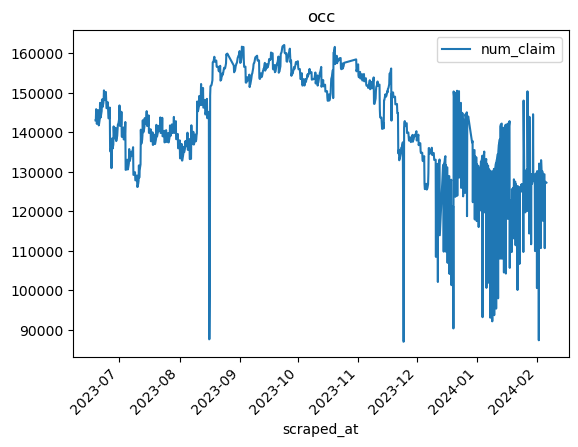

In [9]:
plt.figure(figsize=(18,6))
data = df.where(df.url.startswith("https://www.occ")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).toPandas()
data['scraped_at'] = pd.to_datetime(data['scraped_at'][:-60])
data.plot("scraped_at", "num_claim")
plt.title("occ")
_ = plt.xticks(rotation=45)

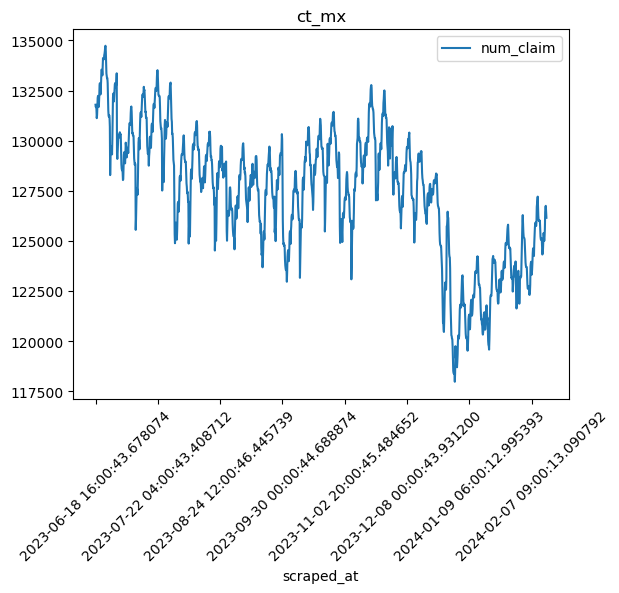

In [10]:
data = df.where(df.url.startswith("https://mx.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).toPandas()
data.plot("scraped_at", "num_claim")
plt.title("ct_mx")
_ = plt.xticks(rotation=45)

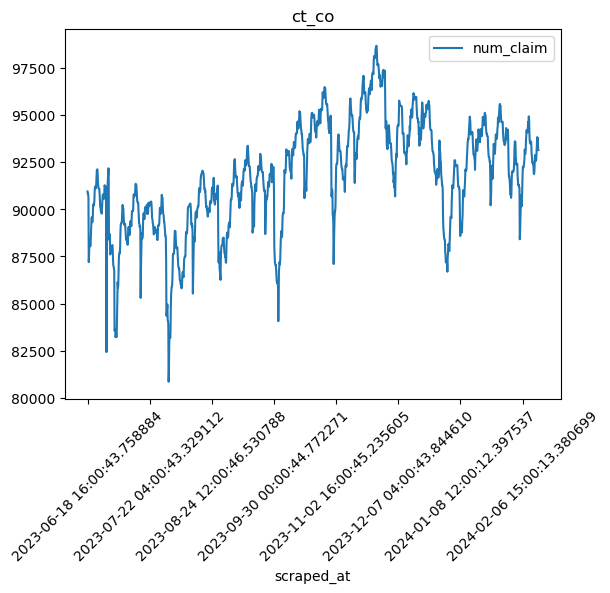

In [11]:
data = df.where(df.url.startswith("https://co.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).toPandas()
data.plot("scraped_at", "num_claim")
plt.title("ct_co")
_ = plt.xticks(rotation=45)

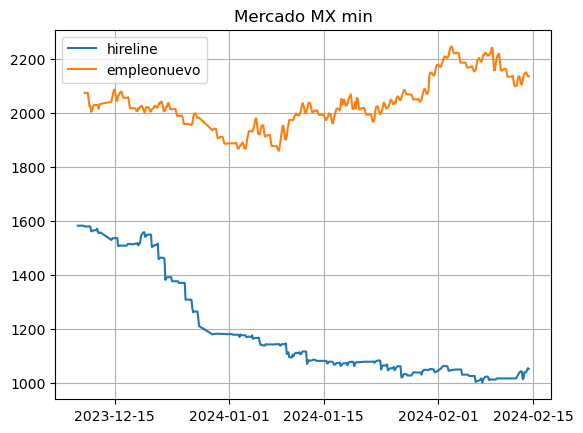

In [12]:
hl = df.where(df.url.startswith("https://hireline.io/mx")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
en = df.where(df.url.startswith("https://www.empleonuevo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
hl['scraped_at'] = pd.to_datetime(hl['scraped_at'])
en['scraped_at'] = pd.to_datetime(en['scraped_at'])
plt.grid(which="both")
plt.title("Mercado MX min")
_=plt.plot(hl.set_index('scraped_at'))
_=plt.plot(en.set_index('scraped_at'))
plt.legend(['hireline', 'empleonuevo'])


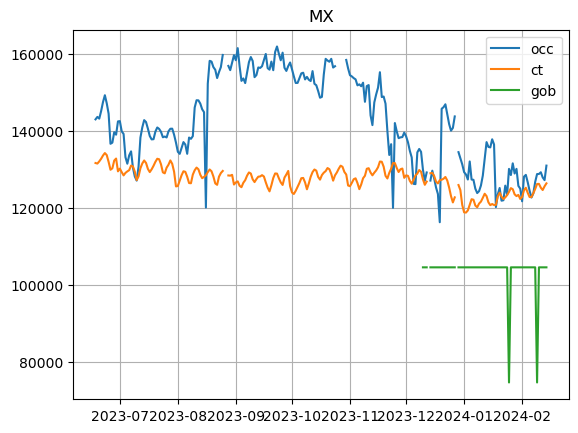

In [13]:
ct = df.where(df.url.startswith("https://mx.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
occ = df.where(df.url.startswith("https://www.occ")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
gob = df.where(df.url.startswith("https://www.empleo.gob.mx")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()

ct['scraped_at'] = pd.to_datetime(ct['scraped_at'])
occ['scraped_at'] = pd.to_datetime(occ['scraped_at'])
gob['scraped_at'] = pd.to_datetime(gob['scraped_at'])

plt.plot(occ.set_index('scraped_at').resample('D').mean())
plt.plot(ct.set_index('scraped_at').resample('D').mean())
plt.plot(gob.set_index('scraped_at').resample('D').mean())
plt.grid(which="both")
plt.legend(['occ', 'ct', 'gob'])
plt.title("MX")
plt.show()

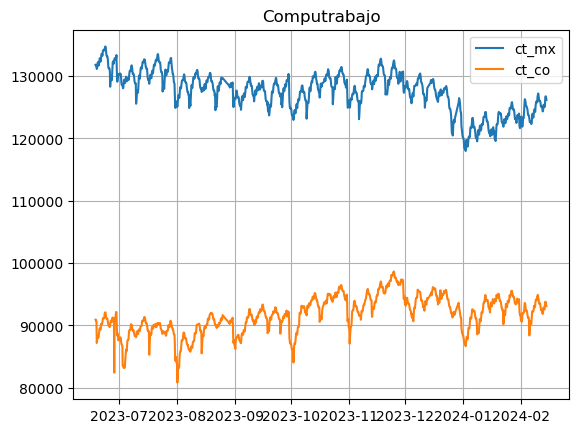

In [14]:
ct_mx = df.where(df.url.startswith("https://mx.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
ct_co = df.where(df.url.startswith("https://co.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()

ct_mx['scraped_at'] = pd.to_datetime(ct_mx['scraped_at'])
ct_co['scraped_at'] = pd.to_datetime(ct_co['scraped_at'])

plt.plot(ct_mx.set_index('scraped_at'))
plt.plot(ct_co.set_index('scraped_at'))
plt.grid(which="both")
plt.legend(["ct_mx", "ct_co"])
plt.title("Computrabajo")
plt.show()

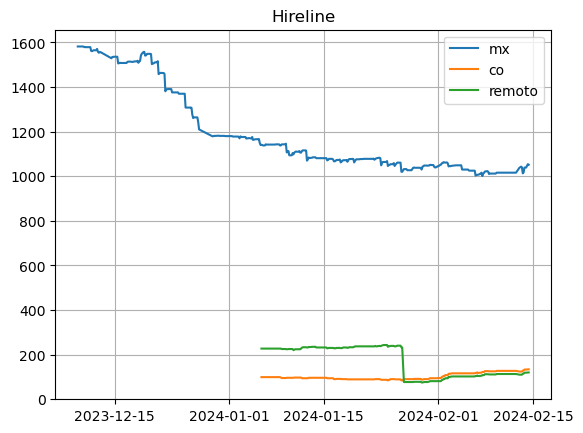

In [15]:
hl_mx = df.where(df.url.startswith("https://hireline.io/mx")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
hl_co = df.where(df.url.startswith("https://hireline.io/co")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
hl_re = df.where(df.url.startswith("https://hireline.io/re")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()

hl_mx['scraped_at'] = pd.to_datetime(hl_mx['scraped_at'])
hl_co['scraped_at'] = pd.to_datetime(hl_co['scraped_at'])
hl_re['scraped_at'] = pd.to_datetime(hl_re['scraped_at'])

plt.plot(hl_mx.set_index('scraped_at'))
plt.plot(hl_co.set_index('scraped_at'))
plt.plot(hl_re.set_index('scraped_at'))
plt.grid(which="both")
plt.legend(["mx", "co", "remoto"])
plt.title("Hireline")
plt.show()